# HRV-Based Early Cardiac Risk Detection with CDED Dataset
This notebook covers data loading, preprocessing, HRV feature extraction from ECG files, merging clinical and HRV data, training multiple models, cross-validation, and hyperparameter tuning.

In [28]:

# Imports and basic setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob
import wfdb
import neurokit2 as nk
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")


## Step 1: Load Clinical CSV Data

In [29]:

base_path = r'C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/cded/DATA_discription/'

demographics_path = os.path.join(base_path, 'GE-79_Summary_Table-Demographics-MRI-Part1.csv')
labs_path = os.path.join(base_path, 'GE-79_Summary_Table-Labs-BP-Ophthalmogic-Walk.csv')
history_path = os.path.join(base_path, 'GE-79_Summary_Table-MRI-Part5-History.csv')

demographics = pd.read_csv(demographics_path, encoding='latin1')
labs_bp = pd.read_csv(labs_path, encoding='latin1')
history = pd.read_csv(history_path, encoding='latin1')

print("Demographics shape:", demographics.shape)
print("Labs shape:", labs_bp.shape)
print("History shape:", history.shape)


Demographics shape: (121, 254)
Labs shape: (121, 170)
History shape: (121, 174)


## Step 2: Preprocess clinical data and merge

In [30]:
print(history.columns.tolist())


['patient ID', 'Visit', 'Perfusion Vascular (Lepto MCA) -  baseline 1 Right - 6 min', 'Perfusion Vascular (Lepto PCA) -  baseline 1 Right - 6 min', 'Perfusion Vascular (MCA Perf) - baseline 1 Right - 6 min', 'Perfusion Vascular (POCA) - baseline 1 Right - 6 min', 'Perfusion Vascular (whole brain) - baseline 1 whole - 6 min', 'Perfusion Vascular (ACA Perf) -  baseline 1 whole - 6 min', 'Perfusion Vascular (ACHA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto ACA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto MCA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (Lepto PCA) -  baseline 1 whole - 6 min', 'Perfusion Vascular (MCA Perf) - baseline 1 whole - 6 min', 'Perfusion Vascular (POCA) - baseline 1 whole - 6 min', 'Perfusion Vascular (whole brain) - baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (ACA Perf) -  baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (ACHA) -  baseline 1 Left Brain (unit: ml/100g/min)', 'Perfusion Vascular (

In [31]:

# Normalize all column names to lower case with underscores
labs_bp.columns = labs_bp.columns.str.strip().str.lower().str.replace(' ', '_')
history.columns = history.columns.str.strip().str.lower().str.replace(' ', '_')
demographics.columns = demographics.columns.str.strip().str.lower().str.replace(' ', '_')

# Check they all aligned
print("Demographics columns:", demographics.columns[:5])
print("Labs columns:", labs_bp.columns[:5])
print("History columns:", history.columns[:5])

#print column
print("Demographics columns:", demographics.columns.tolist())
print("Labs columns:", labs_bp.columns.tolist())
print("History columns:", history.columns.tolist())

# Now merge
df = pd.merge(demographics, labs_bp, on=['patient_id', 'visit'], how='inner')
df = pd.merge(df, history, on=['patient_id', 'visit'], how='left')

print("Merged dataset shape:", df.shape)
print(df[['patient_id', 'visit']].head())

Demographics columns: Index(['patient_id', 'study', 'visit', 'group', 'diabetes_duration'], dtype='object')
Labs columns: Index(['patient_id', 'visit', 'previous_tobacco_use', 'current_tobacco_use',
       'packyears'],
      dtype='object')
History columns: Index(['patient_id', 'visit',
       'perfusion_vascular_(lepto_mca)_-__baseline_1_right_-_6_min',
       'perfusion_vascular_(lepto_pca)_-__baseline_1_right_-_6_min',
       'perfusion_vascular_(mca_perf)_-_baseline_1_right_-_6_min'],
      dtype='object')
Demographics columns: ['patient_id', 'study', 'visit', 'group', 'diabetes_duration', 'htn_or_not', 'race', 'dm,_non-dm,_stroke', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyr

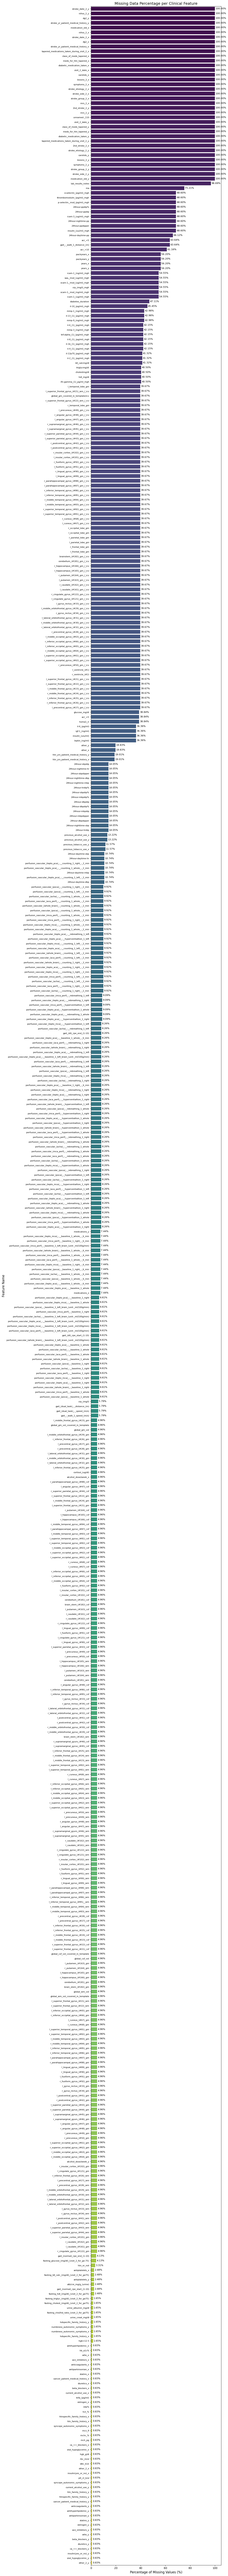

In [32]:


missing_counts = df.isna().sum()
missing_perc = (missing_counts / len(df)) * 100
missing_perc = missing_perc[missing_perc > 0].sort_values(ascending=False)

plt.figure(figsize=(12, max(8, 0.25*len(missing_perc))))  # dynamic height
ax = sns.barplot(x=missing_perc.values, y=missing_perc.index, palette="viridis")

plt.xlabel('Percentage of Missing Values (%)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.title('Missing Data Percentage per Clinical Feature', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=8)  # smaller to avoid clutter

# Add text labels after the bars
for i, v in enumerate(missing_perc.values):
    ax.text(v + 0.5, i, f"{v:.2f}%", color='black', va='center', fontsize=9)

plt.tight_layout()
plt.show()


In [33]:
print(df.columns.tolist())


['patient_id', 'study', 'visit', 'group', 'diabetes_duration', 'htn_or_not', 'race', 'dm,_non-dm,_stroke', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyrus_(#28)_gm', 'l_middle_orbitofrontal_gyrus_(#29)_gm', 'r_middle_orbitofrontal_gyrus_(#30)_gm', 'l_lateral_orbitofrontal_gyrus_(#31)_gm', 'r_lateral_orbitofrontal_gyrus_(#32)_gm', 'l_gyrus_rectus_(#33)_gm', 'r_gyrus_rectus_(#34)_gm', 'l_postcentral_gyrus_(#41)_gm', 'r_postcentral_gyrus_(#42)_gm', 'l_superior_parietal_gyrus_(#43)_gm', 'r_superior_parietal_gyrus_(#44)_gm', 'l_supramarginal_gyrus_(#45)_gm', 'r_supramarginal_gyurs_(#46)_gm', 'l_angular_gyrus_(#47)_gm', 'r_angular_gyrus_(#48)_gm', 'l_precuneus_(#49)_gm', 'r_precuneus_(#50

## Step 3: Define CAN risk label from clinical columns

In [34]:
# Show unique values in those columns to verify
print(df['dm,_non-dm,_stroke'].unique())
print(df['htn_or_not'].unique())

autonomic_cols = [
    'dizziness_autonomic_symptoms_x',
    'syncope_autonomic_symptoms_x',
    'oh_autonomic_symptoms_x'
]
print(df[autonomic_cols].head())

def define_can_risk(row):
    has_diabetes = row['dm,_non-dm,_stroke'] == 'DM'   # exact string match for diabetes label
    has_htn = row['htn_or_not'] == 'HTN'                # exact string match for HTN label

    autonomic_cols = [
        'dizziness_autonomic_symptoms_x',
        'syncope_autonomic_symptoms_x',
        'oh_autonomic_symptoms_x'
    ]
    
    has_autonomic = any(
        str(row[col]).strip().upper() == 'YES'
        for col in autonomic_cols
        if col in row and pd.notna(row[col])
    )

    if has_diabetes and (has_autonomic or has_htn):
        return 1
    else:
        return 0

df['CAN_risk_label'] = df.apply(define_can_risk, axis=1)

print(df['CAN_risk_label'].value_counts())


['Non-DM' 'DM']
['ntn' 'HTN' nan]
  dizziness_autonomic_symptoms_x syncope_autonomic_symptoms_x  \
0                             NO                           NO   
1                             NO                           NO   
2                             NO                           NO   
3                             NO                           NO   
4                             NO                           NO   

  oh_autonomic_symptoms_x  
0                      NO  
1                      NO  
2                      NO  
3                      NO  
4                      NO  
CAN_risk_label
0    66
1    55
Name: count, dtype: int64


## Step 4: Extract HRV features from ECG records

In [35]:

ecg_folder = r'C:/Users/r/Machine_Learning/HRV Early cardiac risk detection/cded/Data/ECG/'

hrv_list = []

for record_path in glob.glob(os.path.join(ecg_folder, '*ECG.hea')):
    record_name = os.path.splitext(os.path.basename(record_path))[0].replace('.hea','')
    try:
        record = wfdb.rdrecord(os.path.join(ecg_folder, record_name))
        ecg_signal = record.p_signal[:, 0]  # first channel
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=record.fs)
        hrv = nk.hrv_time(signals["ECG_R_Peaks"], sampling_rate=record.fs)
        hrv['patient_id'] = record_name[:5]  # adjust if needed
        hrv['visit'] = 2  # set visit (adjust if known)
        hrv_list.append(hrv)
    except Exception as e:
        print(f"Failed {record_name}: {e}")

df_hrv = pd.concat(hrv_list, ignore_index=True)
print(df_hrv.head())


   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  879.029586   76.276373   76.742899   26.111553   69.216742   39.507039   
1  982.590571  123.302236   84.304607   89.460749   64.294791   88.414396   
2  685.945355   53.959304   59.012233   19.816811   49.785432   32.498280   
3  758.582359  228.805327  196.530270   94.513943  139.704868  130.124056   
4  759.156627  293.123764   96.469767  264.880697  101.417513  265.055038   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_Prc20NN  \
0         NaN         NaN   20.713638   20.728922  ...        821.0   
1         NaN         NaN   65.333454   65.414853  ...        956.0   
2         NaN         NaN   14.399222   14.406518  ...        651.0   
3         NaN         NaN  133.358894  133.361227  ...        631.0   
4         NaN         NaN  391.413609  391.807815  ...        583.8   

   HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN    HRV_HTI  \
0        961.0   1.479290  17.307692 

## Step 5: Merge clinical data with HRV features (Left join) and Impute missing HRV

In [36]:

df_full = pd.merge(df, df_hrv, on=['patient_id', 'visit'], how='left')

print("Merged dataset shape:", df_full.shape)

missing_hrv_count = df_full['HRV_MeanNN'].isna().sum()
print(f"Missing HRV feature rows: {missing_hrv_count} out of {df_full.shape[0]}")

df_full['hrv_available'] = df_full['HRV_MeanNN'].notna().astype(int)

hrv_columns = df_hrv.columns.drop(['patient_id', 'visit'])

for col in hrv_columns:
    median_val = df_full[col].median()
    df_full[col].fillna(median_val, inplace=True)

print("After imputation, missing values per column:")
print(df_full[hrv_columns].isna().sum())


Merged dataset shape: (121, 620)
Missing HRV feature rows: 79 out of 121
After imputation, missing values per column:
HRV_MeanNN      0
HRV_SDNN        0
HRV_SDANN1      0
HRV_SDNNI1      0
HRV_SDANN2      0
HRV_SDNNI2      0
HRV_SDANN5      0
HRV_SDNNI5      0
HRV_RMSSD       0
HRV_SDSD        0
HRV_CVNN        0
HRV_CVSD        0
HRV_MedianNN    0
HRV_MadNN       0
HRV_MCVNN       0
HRV_IQRNN       0
HRV_SDRMSSD     0
HRV_Prc20NN     0
HRV_Prc80NN     0
HRV_pNN50       0
HRV_pNN20       0
HRV_MinNN       0
HRV_MaxNN       0
HRV_HTI         0
HRV_TINN        0
dtype: int64


## Step 6: Prepare features and target for modeling

In [63]:

features_to_drop = [
    'patient_id', 'visit', 'dm,_non-dm,_stroke', 'htn_or_not',
    'dizziness_autonomic_symptoms_x', 'syncope_autonomic_symptoms_x',
    'oh_autonomic_symptoms_x', 'CAN_risk_label'
]

X = df_full.drop(columns=features_to_drop).select_dtypes(include=[np.number])
y = df_full['CAN_risk_label']


print(f"Feature shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")


Feature shape: (121, 531)
Target distribution:
CAN_risk_label
0    66
1    55
Name: count, dtype: int64


In [78]:
# ---- Print columns used in training ----
print("\n=== Columns used for training (features in X) ===")
print(list(X.columns))



=== Columns used for training (features in X) ===
['diabetes_duration', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyrus_(#28)_gm', 'l_middle_orbitofrontal_gyrus_(#29)_gm', 'r_middle_orbitofrontal_gyrus_(#30)_gm', 'l_lateral_orbitofrontal_gyrus_(#31)_gm', 'r_lateral_orbitofrontal_gyrus_(#32)_gm', 'l_gyrus_rectus_(#33)_gm', 'r_gyrus_rectus_(#34)_gm', 'l_postcentral_gyrus_(#41)_gm', 'r_postcentral_gyrus_(#42)_gm', 'l_superior_parietal_gyrus_(#43)_gm', 'r_superior_parietal_gyrus_(#44)_gm', 'l_supramarginal_gyrus_(#45)_gm', 'r_supramarginal_gyurs_(#46)_gm', 'l_angular_gyrus_(#47)_gm', 'r_angular_gyrus_(#48)_gm', 'l_precuneus_(#49)_gm', 'r_precuneus_(#50)_gm', 'l_superior_occipital_gyrus

In [77]:
print("Columns used in training:", list(X.columns))


Columns used in training: ['diabetes_duration', 'height_(m)', 'mass_(kg)', 'bmi', 'global_gm_vol', 'global_gm_vol_covered_in_template', 'l_superior_frontal_gyrus_(#21)_gm', 'r_superior_frontal_gyrus_(#22)_gm', 'l_middle_frontal_gyrus_(#23)_gm', 'r_middle_frontal_gyrus_(#24)_gm', 'l_inferior_frontal_gyrus_(#25)_gm', 'r_inferior_frontal_gyrus_(#26)_gm', 'l_precentral_gyrus_(#27)_gm', 'r_precentral_gyrus_(#28)_gm', 'l_middle_orbitofrontal_gyrus_(#29)_gm', 'r_middle_orbitofrontal_gyrus_(#30)_gm', 'l_lateral_orbitofrontal_gyrus_(#31)_gm', 'r_lateral_orbitofrontal_gyrus_(#32)_gm', 'l_gyrus_rectus_(#33)_gm', 'r_gyrus_rectus_(#34)_gm', 'l_postcentral_gyrus_(#41)_gm', 'r_postcentral_gyrus_(#42)_gm', 'l_superior_parietal_gyrus_(#43)_gm', 'r_superior_parietal_gyrus_(#44)_gm', 'l_supramarginal_gyrus_(#45)_gm', 'r_supramarginal_gyurs_(#46)_gm', 'l_angular_gyrus_(#47)_gm', 'r_angular_gyrus_(#48)_gm', 'l_precuneus_(#49)_gm', 'r_precuneus_(#50)_gm', 'l_superior_occipital_gyrus_(#61)_gm', 'r_superior_o

In [64]:
print("Total data points in the final dataset:", df_full.shape[0])


Total data points in the final dataset: 121


In [69]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = dict(zip(np.unique(y), class_weights))
print("Class weights:", weight_dict)

# Calculate scale_pos_weight for XGBoost (assumes binary classes 0 and 1)
scale_pos_weight = weight_dict[0] / weight_dict[1]
print("XGBoost scale_pos_weight:", scale_pos_weight)


Class weights: {np.int64(0): np.float64(0.9166666666666666), np.int64(1): np.float64(1.1)}
XGBoost scale_pos_weight: 0.8333333333333333


## Step 7: Scale features and cross-validate multiple models

In [75]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                             scale_pos_weight=scale_pos_weight),  # Add this param
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
# Scale features explicitly (before CV)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use RandomForest to select features (threshold can be median or any quantile)
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='median')
selector.fit(X_scaled, y)

X_selected = selector.transform(X_scaled)
print(f"Selected feature shape: {X_selected.shape}")

for name, model in models.items():
    print(f"Running CV for {name}...")
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # ('scaler', StandardScaler()),  # Remove scaler, already scaled
        ('clf', model)
    ])
    scores = cross_val_score(pipe, X_selected, y, cv=skf, scoring='accuracy', n_jobs=-1)
    results[name] = scores
    print(f"{name} CV accuracy scores: {scores}")
    print(f"{name} Mean accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})\n")


Selected feature shape: (121, 266)
Running CV for Random Forest...
Random Forest CV accuracy scores: [0.88       0.875      0.91666667 0.95833333 0.875     ]
Random Forest Mean accuracy: 0.9010 (+/- 0.0326)

Running CV for Logistic Regression...
Logistic Regression CV accuracy scores: [0.92       0.83333333 0.875      0.75       0.83333333]
Logistic Regression Mean accuracy: 0.8423 (+/- 0.0562)

Running CV for XGBoost...
XGBoost CV accuracy scores: [0.88       0.83333333 0.875      0.95833333 0.95833333]
XGBoost Mean accuracy: 0.9010 (+/- 0.0495)

Running CV for KNN...
KNN CV accuracy scores: [0.68       0.66666667 0.66666667 0.58333333 0.66666667]
KNN Mean accuracy: 0.6527 (+/- 0.0350)

Running CV for SVM...
SVM CV accuracy scores: [0.8        0.75       0.70833333 0.70833333 0.79166667]
SVM Mean accuracy: 0.7517 (+/- 0.0392)

Running CV for LightGBM...
LightGBM CV accuracy scores: [0.92       0.875      0.91666667 0.95833333 0.875     ]
LightGBM Mean accuracy: 0.9090 (+/- 0.0314)

Ru

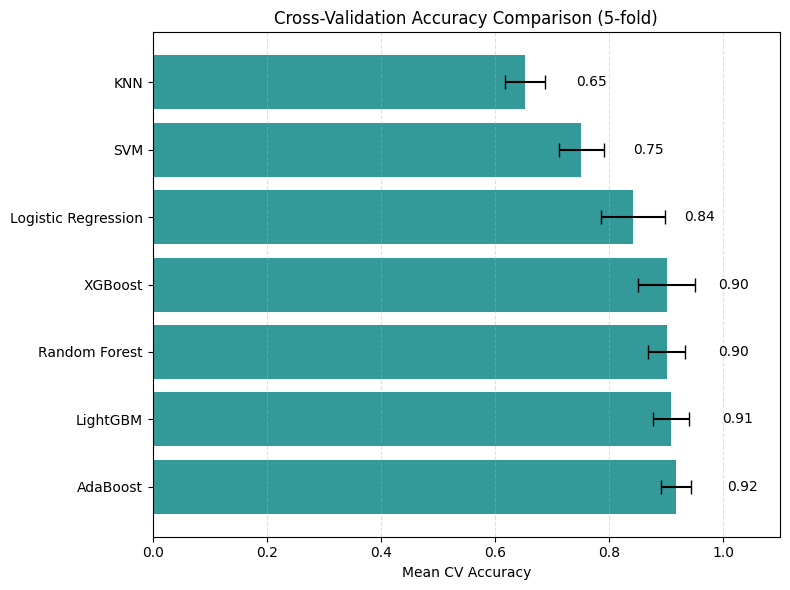

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results dictionary is ready
cv_means = {model: np.mean(scores) for model, scores in results.items()}
cv_stds = {model: np.std(scores) for model, scores in results.items()}

# Sort models
sorted_models = sorted(cv_means, key=cv_means.get, reverse=True)
mean_values = [cv_means[model] for model in sorted_models]
std_values = [cv_stds[model] for model in sorted_models]

# Plot
plt.figure(figsize=(8,6))
bars = plt.barh(sorted_models, mean_values, xerr=std_values, color='teal', alpha=0.8, capsize=5)

# Add value labels slightly to the right of the bars
for bar, mean in zip(bars, mean_values):
    plt.text(mean + 0.09, bar.get_y() + bar.get_height()/2, f'{mean:.2f}', va='center')

plt.xlabel('Mean CV Accuracy')
plt.title('Cross-Validation Accuracy Comparison (5-fold)')
plt.xlim(0, 1.1)  # Extend x-axis to leave room for labels
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [72]:
param_grids = {
    'Random Forest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5],
        'clf__min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [3, 4, 5],
        'clf__learning_rate': [0.1, 0.2, 0.3],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0],
        'clf__reg_alpha': [0, 0.1, 1],
        'clf__reg_lambda': [1, 2],
        'clf__gamma': [0, 0.1]
    },
    'LightGBM': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [-1, 10, 20],
        'clf__learning_rate': [0.05, 0.1, 0.2],
        'clf__num_leaves': [31, 50, 100]
    },
    'AdaBoost': {
        'clf__n_estimators': [50, 100, 200],
        'clf__learning_rate': [0.01, 0.1, 1.0]
    }
}


In [73]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

best_estimators = {}

for model_name in ['Random Forest', 'XGBoost', 'LightGBM', 'AdaBoost']:
    print(f"Running GridSearchCV for {model_name}...")
    
    model = models[model_name]
    
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        # No scaler here because you already scaled & selected features before, 
        # but if you want, you can add scaler here and run grid on unscaled X as well.
        ('clf', model)
    ])
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[model_name],
        scoring='accuracy',
        cv=skf,
        n_jobs=-1,
        verbose=2
    )
    
    grid.fit(X_selected, y)
    print(f"Best parameters for {model_name}: {grid.best_params_}")
    print(f"Best CV accuracy for {model_name}: {grid.best_score_:.4f}\n")
    
    best_estimators[model_name] = grid.best_estimator_


Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best CV accuracy for Random Forest: 0.9173

Running GridSearchCV for XGBoost...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters for XGBoost: {'clf__colsample_bytree': 1.0, 'clf__gamma': 0.1, 'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 100, 'clf__reg_alpha': 0.1, 'clf__reg_lambda': 1, 'clf__subsample': 1.0}
Best CV accuracy for XGBoost: 0.9343

Running GridSearchCV for LightGBM...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Info] Number of positive: 55, number of negative: 66
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

## Step 8: Hyperparameter tuning for XGBoost

In [68]:

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2],
    'gamma': [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                            scale_pos_weight=scale_pos_weight),
    param_grid=param_grid,
    scoring='accuracy',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_scaled, y)

print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.8}
Best CV accuracy: 0.9337


## Step 9: Final evaluation with tuned model

In [93]:

best_model = grid_search.best_estimator_

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[30  3]
 [ 3 25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        33
           1       0.89      0.89      0.89        28

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



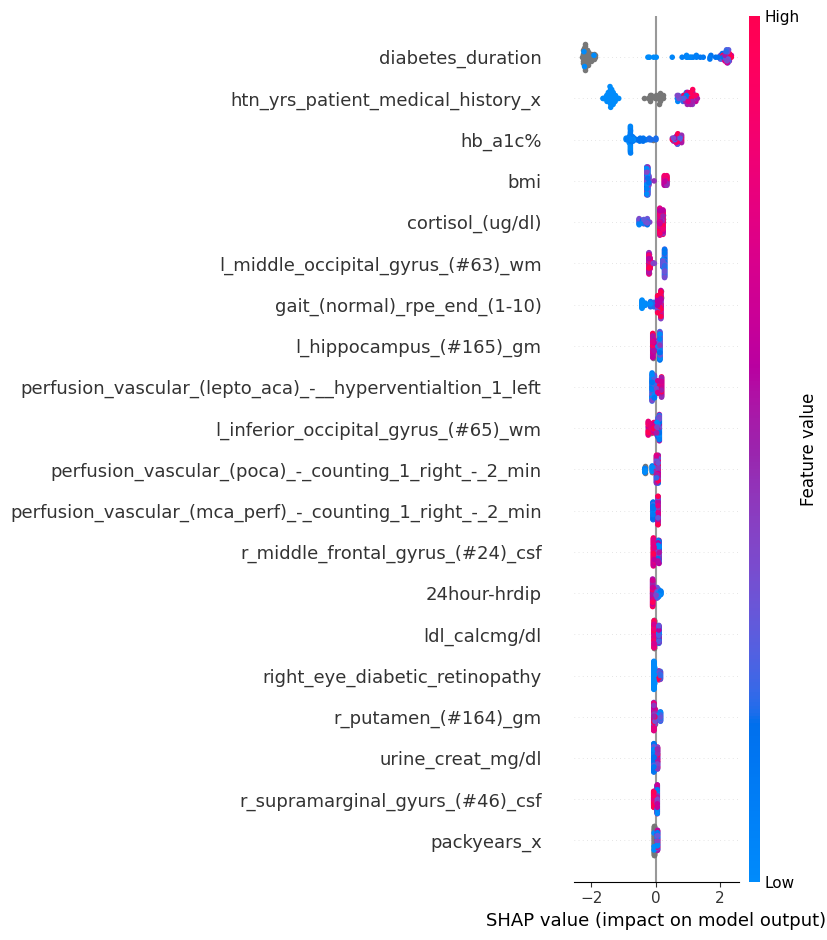

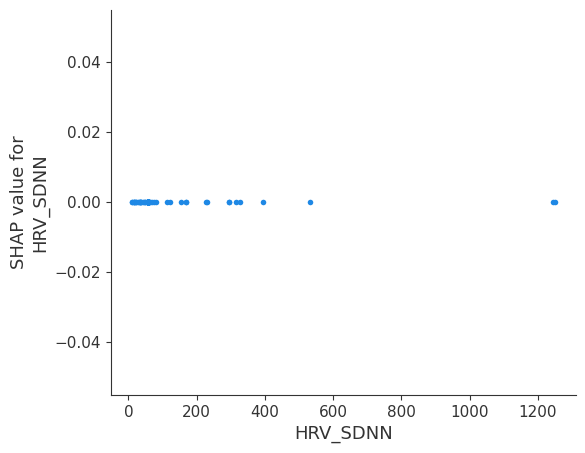

In [45]:
# Step 1: Install SHAP if not installed (run this once in your environment)

import shap

# Step 2: Create a SHAP explainer for the trained XGBoost model
explainer = shap.Explainer(best_model)

# Step 3: Calculate SHAP values for your dataset (use scaled features)
shap_values = explainer(X_scaled)

# Step 4: Summary plot - shows overall feature importance and directionality
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Step 5 (Optional): Dependence plot for a specific important feature
# Replace 'HRV_SDNN' with any feature from your dataset you want to inspect
shap.dependence_plot('HRV_SDNN', shap_values.values, X, interaction_index=None)

# Step 6 (Optional): Force plot for a single prediction (example: first sample)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X.iloc[0])


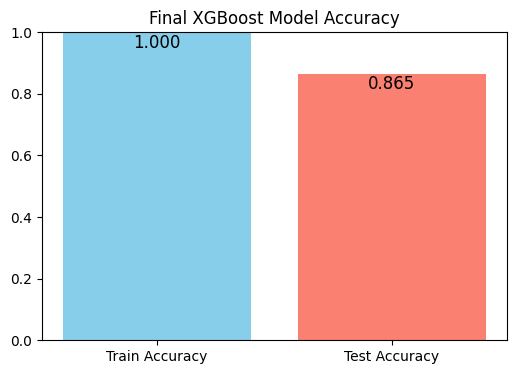

In [79]:
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)

plt.figure(figsize=(6,4))
bars = plt.bar(['Train Accuracy', 'Test Accuracy'], [train_acc, test_acc], color=['skyblue', 'salmon'])
plt.ylim(0,1)
plt.title('Final XGBoost Model Accuracy')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height - 0.05, f'{height:.3f}', ha='center', color='black', fontsize=12)
plt.show()


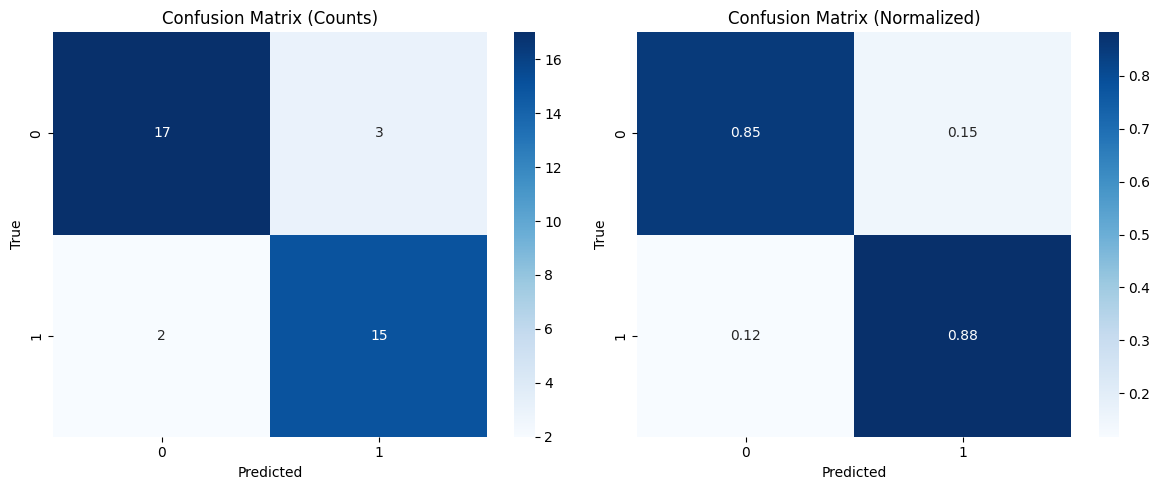

In [80]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix (Counts)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix (Normalized)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.tight_layout()
plt.show()


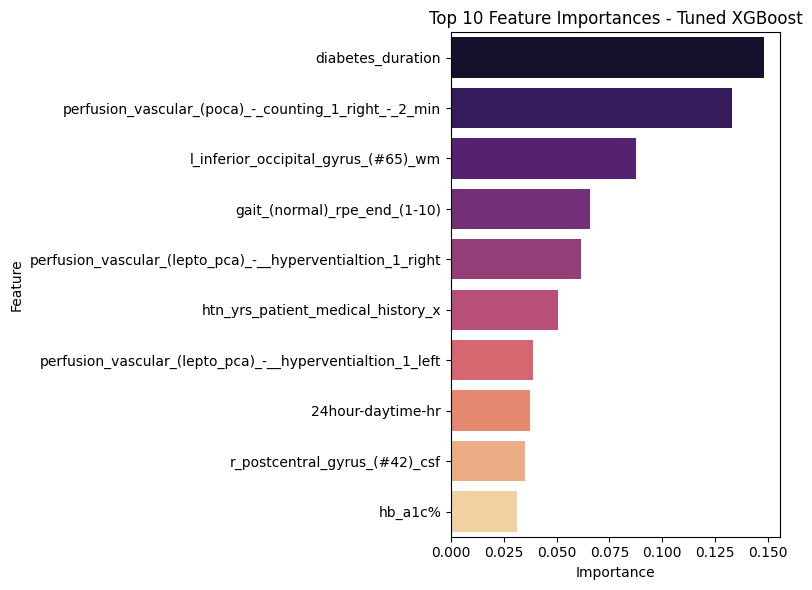

In [81]:
# Extract feature importance from the best XGBoost model
importances = best_model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({'feature': features, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df, palette='magma')
plt.title('Top 10 Feature Importances - Tuned XGBoost')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


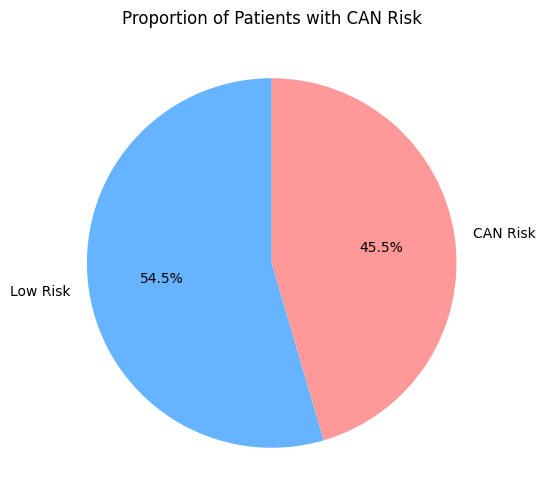

In [82]:
# Pie chart for CAN Risk
risk_counts = df_full['CAN_risk_label'].value_counts().reindex([0,1], fill_value=0)

plt.figure(figsize=(6,6))
plt.pie(risk_counts, labels=["Low Risk", "CAN Risk"], autopct='%1.1f%%', colors=["#66b3ff", "#ff9999"], startangle=90)
plt.title("Proportion of Patients with CAN Risk")
plt.show()


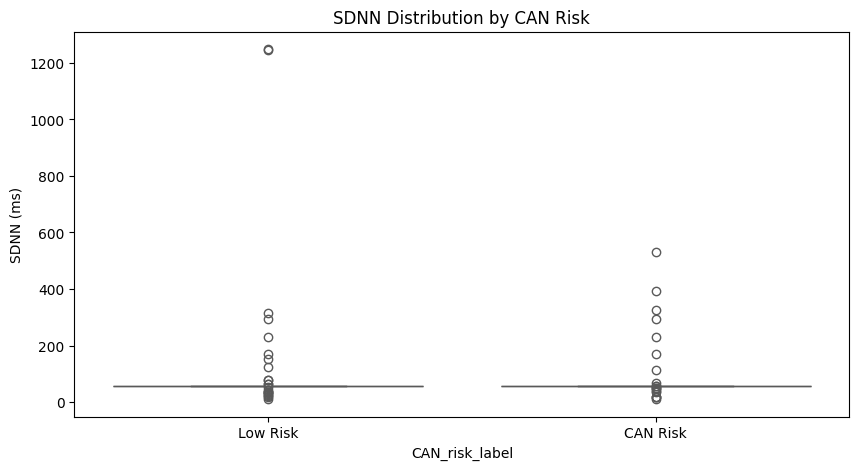

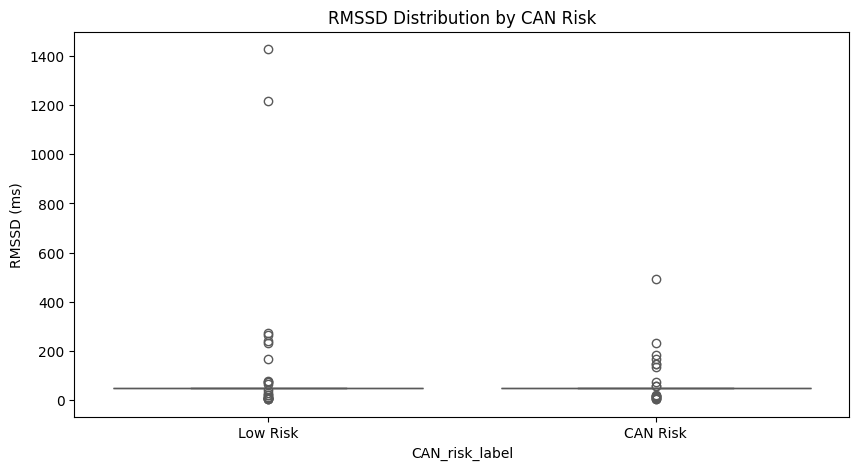

In [83]:
plt.figure(figsize=(10,5))
sns.boxplot(x='CAN_risk_label', y='HRV_SDNN', data=df_full, palette="Set2")
plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
plt.title("SDNN Distribution by CAN Risk")
plt.ylabel("SDNN (ms)")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='CAN_risk_label', y='HRV_RMSSD', data=df_full, palette="Set2")
plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
plt.title("RMSSD Distribution by CAN Risk")
plt.ylabel("RMSSD (ms)")
plt.show()


In [84]:
df_plot = df_full.copy()
df_plot['CAN Risk'] = df_plot['CAN_risk_label'].map({0: 'Low Risk', 1: 'CAN Risk'})

# Select columns to plot - choose only columns that exist
cols_to_plot = ['HRV_SDNN', 'HRV_RMSSD']

# Add LF/HF ratio if exists
if 'HRV_LF_HF_ratio' in df_plot.columns:
    cols_to_plot.append('HRV_LF_HF_ratio')

cols_to_plot.append('CAN Risk')  # target for hue

print("Plotting HRV features:", cols_to_plot)


Plotting HRV features: ['HRV_SDNN', 'HRV_RMSSD', 'CAN Risk']


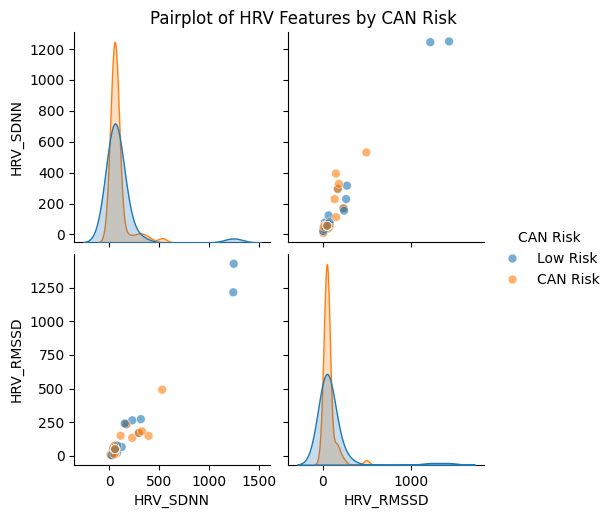

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df_plot[cols_to_plot], hue='CAN Risk', diag_kind='kde', plot_kws={'alpha':0.6, 's':40})
plt.suptitle("Pairplot of HRV Features by CAN Risk", y=1.02)
plt.show()


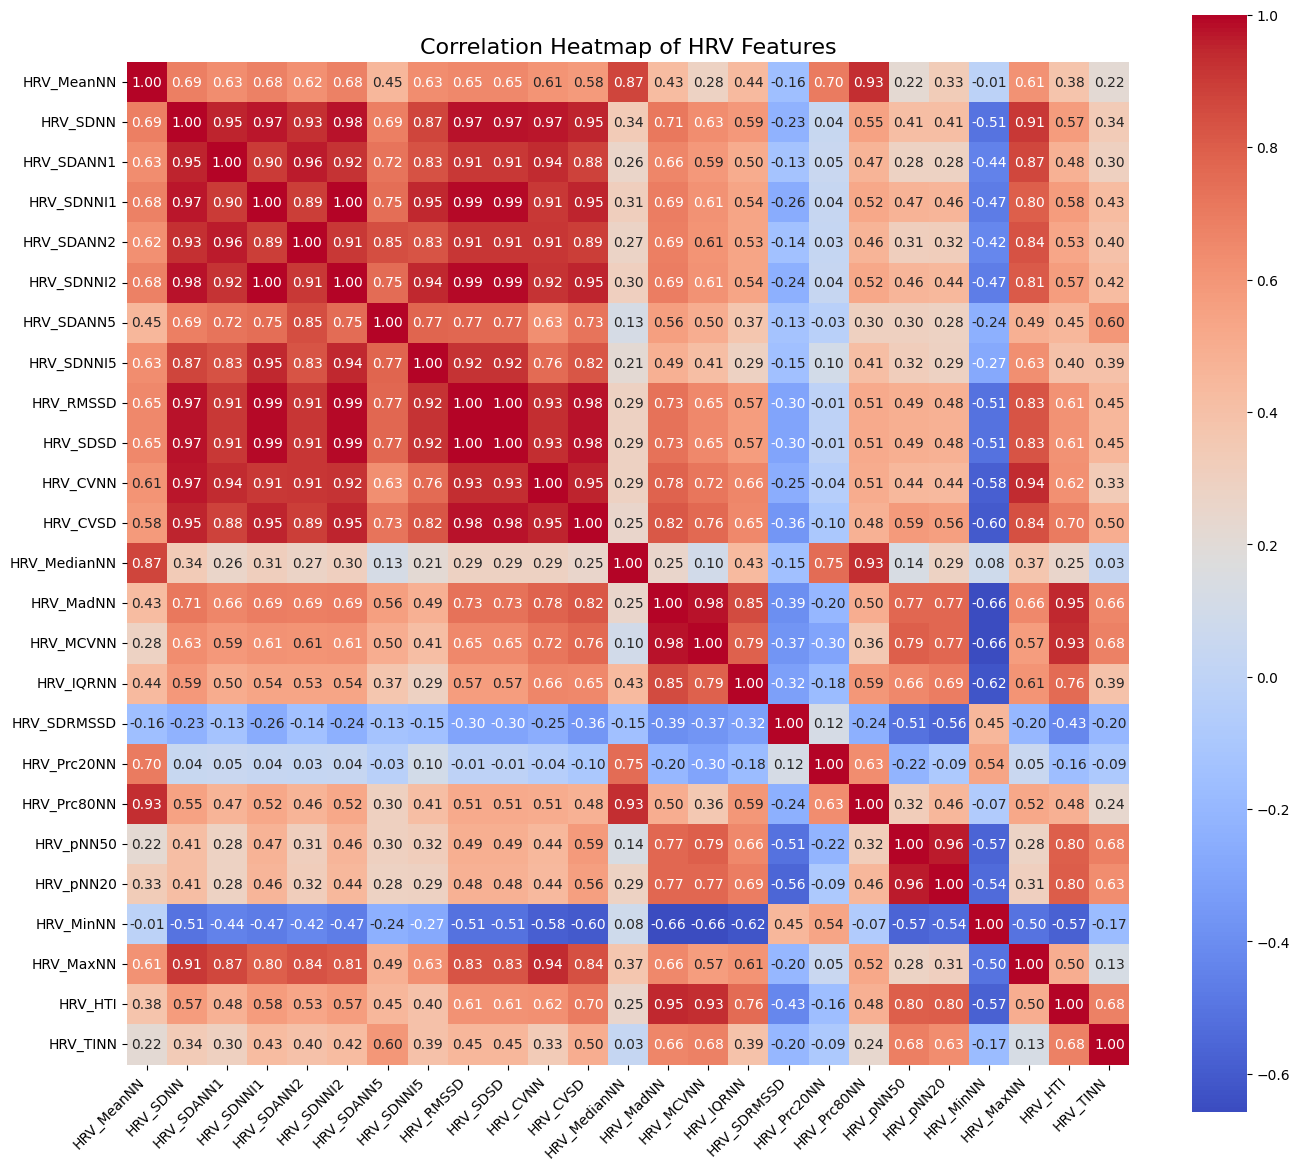

In [86]:
# Define HRV columns
hrv_cols_existing = [col for col in df_full.columns if col.startswith('HRV_')]

# Then plot correlation heatmap
plt.figure(figsize=(14,12))
sns.heatmap(df_full[hrv_cols_existing].corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of HRV Features", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


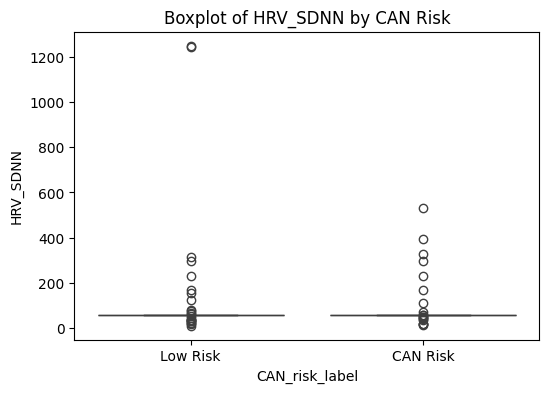

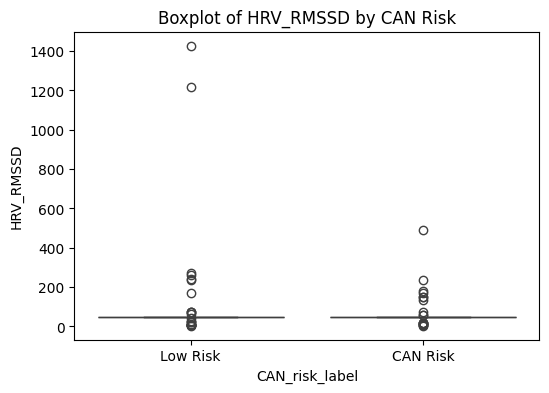

In [87]:
key_hrv_feats = ['HRV_SDNN', 'HRV_RMSSD']
for feat in key_hrv_feats:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='CAN_risk_label', y=feat, data=df_full)
    plt.xticks([0,1], ['Low Risk', 'CAN Risk'])
    plt.title(f"Boxplot of {feat} by CAN Risk")
    plt.show()


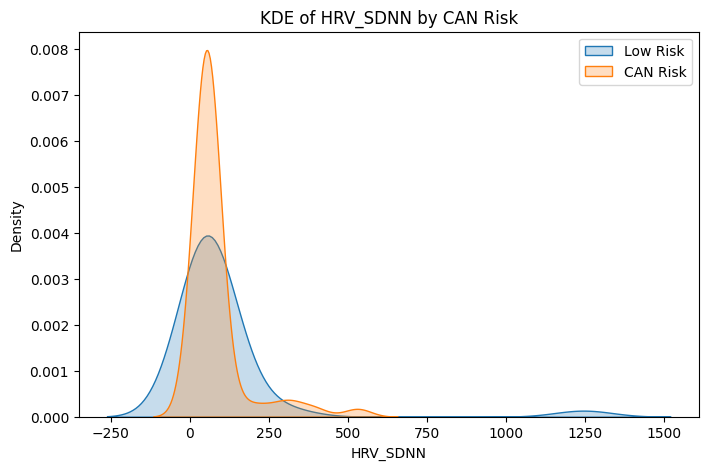

In [88]:
plt.figure(figsize=(8,5))
sns.kdeplot(df_full.loc[df_full['CAN_risk_label']==0, 'HRV_SDNN'], label='Low Risk', shade=True)
sns.kdeplot(df_full.loc[df_full['CAN_risk_label']==1, 'HRV_SDNN'], label='CAN Risk', shade=True)
plt.title("KDE of HRV_SDNN by CAN Risk")
plt.xlabel('HRV_SDNN')
plt.legend()
plt.show()


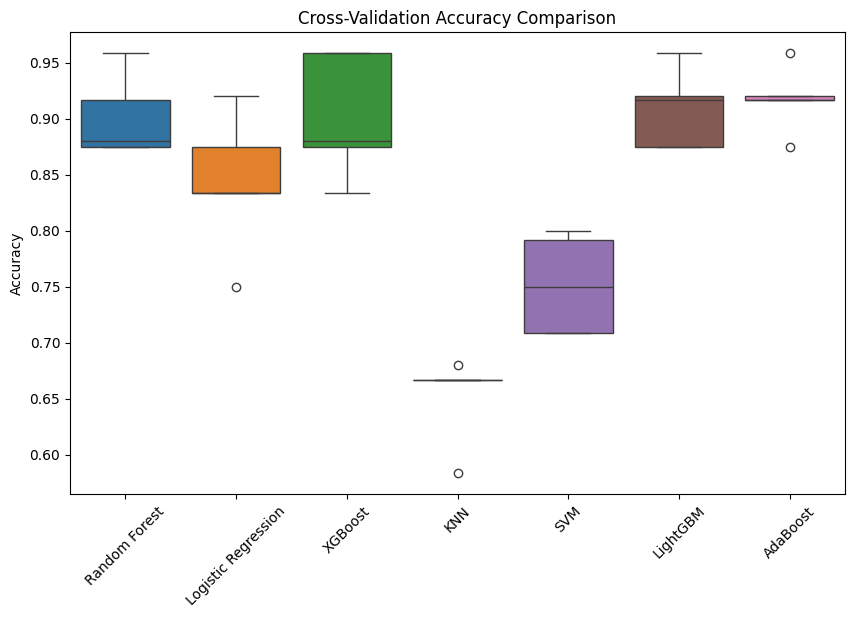

In [89]:
cv_results_df = pd.DataFrame({k: v for k, v in results.items()})
plt.figure(figsize=(10,6))
sns.boxplot(data=cv_results_df)
plt.title("Cross-Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()


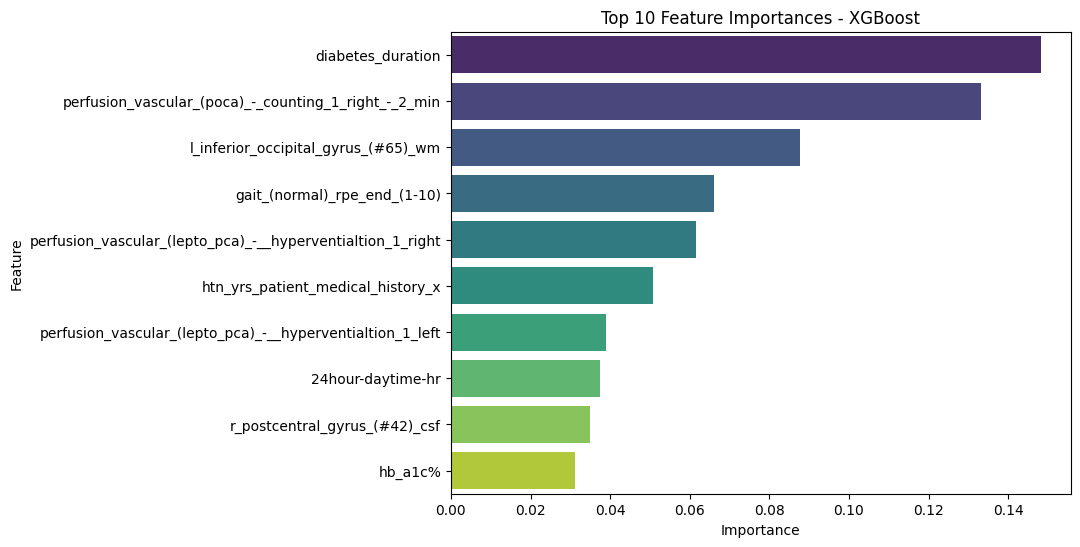

In [90]:
importances = best_model.feature_importances_
feat_names = X.columns

feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(8,6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()
